In [7]:
import pandas as pd
import time
from os.path import join
import json 
import numpy as np 
from tqdm import tqdm
import seaborn as sns
from os import listdir, path
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno


In [8]:

def map_failure(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('comp',''))
    return x

def map_error(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('error',''))
    return x


In [10]:
data_dir = '/workspaces/predictive_maintenance/data/raw'

listdir(data_dir)

# keep only the files that end with .parquet
files = [join(data_dir,f)  for f in listdir(data_dir) if f.endswith('.parquet')]


# creat a dict key is the file name and value is the path 
files_dict = {f.split('/')[-1].split('.')[0]:f for f in files}
files_dict

{'PdM_failures': '/workspaces/predictive_maintenance/data/raw/PdM_failures.parquet',
 'PdM_machines': '/workspaces/predictive_maintenance/data/raw/PdM_machines.parquet',
 'PdM_telemetry2': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry2.parquet',
 'PdM_errors': '/workspaces/predictive_maintenance/data/raw/PdM_errors.parquet',
 'PdM_maint': '/workspaces/predictive_maintenance/data/raw/PdM_maint.parquet',
 'PdM_telemetry': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry.parquet'}

In [11]:
# read all the files into dataframes, the name of the dataframe is df_ + the name of the file


df_PdM_errors = pd.read_parquet(files_dict['PdM_errors'])
df_PdM_maint = pd.read_parquet(files_dict['PdM_maint'])
df_PdM_telemetry = pd.read_parquet(files_dict['PdM_telemetry'])
df_PdM_failures = pd.read_parquet(files_dict['PdM_failures'])
df_PdM_machines = pd.read_parquet(files_dict['PdM_machines'])
    

In [15]:
# convert the date columns to datetime
df_PdM_errors['datetime'] = pd.to_datetime(df_PdM_errors['datetime'])
df_PdM_maint['datetime'] = pd.to_datetime(df_PdM_maint['datetime'])
df_PdM_telemetry['datetime'] = pd.to_datetime(df_PdM_telemetry['datetime'])
df_PdM_failures['datetime'] = pd.to_datetime(df_PdM_failures['datetime'])



In [17]:
# leave last 3 months for testing
train_end_date = '2015-10-01'
df_PdM_telemetry = df_PdM_telemetry[df_PdM_telemetry['datetime'] < train_end_date]
df_PdM_errors = df_PdM_errors[df_PdM_errors['datetime'] < train_end_date]
df_PdM_maint = df_PdM_maint[df_PdM_maint['datetime'] < train_end_date]
df_PdM_failures = df_PdM_failures[df_PdM_failures['datetime'] < train_end_date]



In [18]:
df_PdM_telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
873880,2015-09-30 19:00:00,100,177.465422,546.356723,104.136653,43.033768
873881,2015-09-30 20:00:00,100,184.768905,436.609450,100.804513,41.929488
873882,2015-09-30 21:00:00,100,165.606961,398.096738,91.812868,37.269570
873883,2015-09-30 22:00:00,100,180.035583,511.542831,115.793564,39.715842


In [19]:
# Analisis Univariado 

<AxesSubplot: >

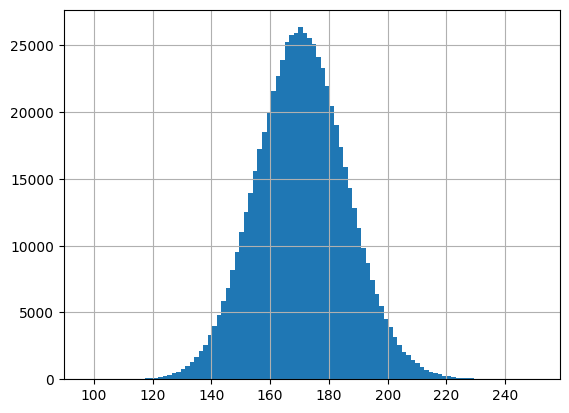

In [23]:
# histogram of volt 
df_PdM_telemetry['volt'].hist(bins=100)



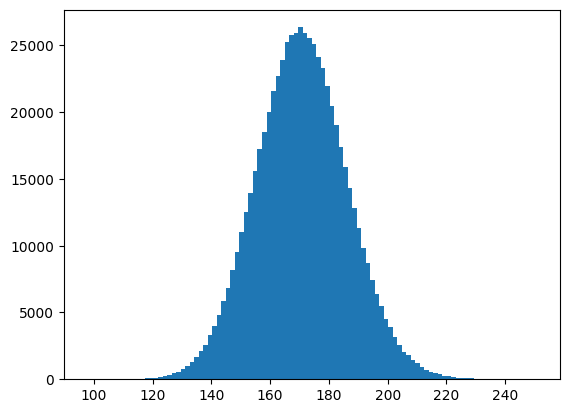

AttributeError: Rectangle.set() got an unexpected keyword argument 'grid'

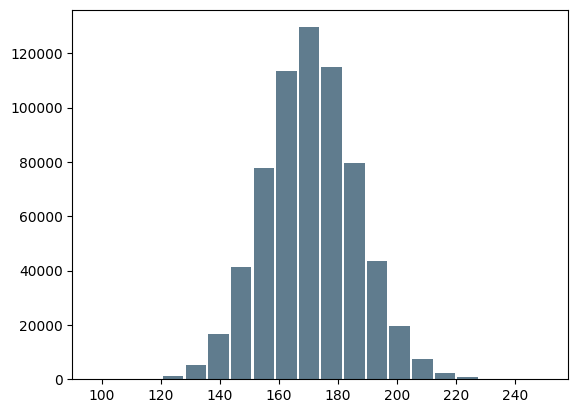

In [27]:
# Crear histograma
plt.hist(df_PdM_telemetry['volt'], bins=100)

# Mostrar gráfico
plt.show()


plt.hist(df_PdM_telemetry['volt'],grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Commute Times for 1,000 Commuters')
plt.xlabel('Counts')
plt.ylabel('Commute Time')
plt.grid(axis='y', alpha=0.75)

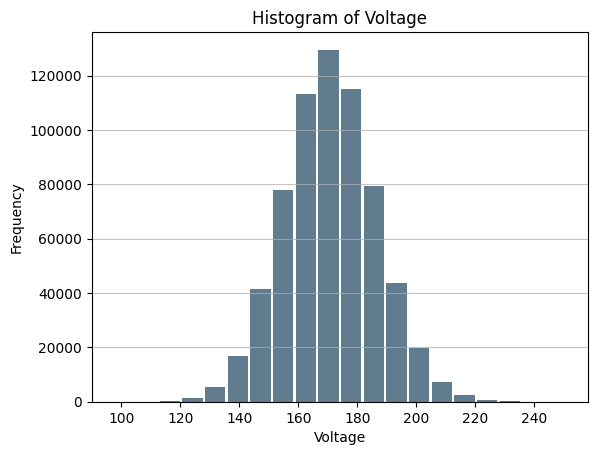

In [28]:

plt.hist(df_PdM_telemetry['volt'], bins=20, rwidth=0.9, color='#607c8e')
plt.title('Histogram of Voltage')
plt.xlabel('Voltage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

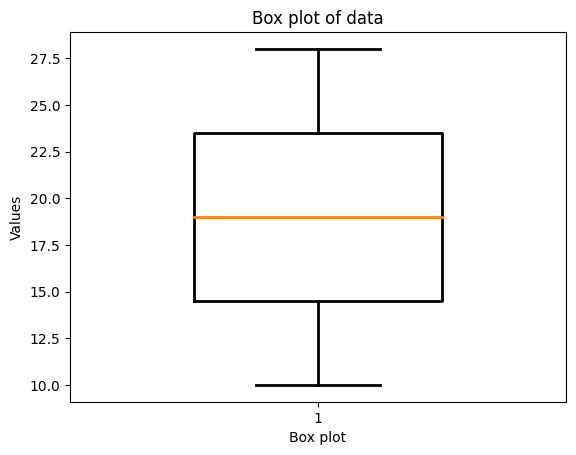

In [31]:
import matplotlib.pyplot as plt

# Crear datos de ejemplo
data = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

# Crear box plot horizontal
plt.boxplot(data, vert=True, widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2), whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2))

# Añadir título y etiquetas de eje
plt.title('Box plot of data')
plt.xlabel('Box plot')
plt.ylabel('Values')

# Mostrar gráfico
plt.show()


In [34]:
data = np.random.normal(10, 3, 1000)

# Crear 10 segmentos del mismo tamaño basados en el rango de la variable
bins = pd.cut(data, 10)



[(12.0, 13.739], (5.04, 6.78], (5.04, 6.78], (12.0, 13.739], (10.26, 12.0], ..., (6.78, 8.52], (6.78, 8.52], (12.0, 13.739], (3.301, 5.04], (8.52, 10.26]]
Length: 1000
Categories (10, interval[float64, right]): [(1.544, 3.301] < (3.301, 5.04] < (5.04, 6.78] < (6.78, 8.52] ... (12.0, 13.739] < (13.739, 15.479] < (15.479, 17.219] < (17.219, 18.959]]

In [109]:
import matplotlib.pyplot as plt

def plot_histogram(df, column):
    plt.hist(df[column], bins=20, rwidth=0.9, color='#607c8e')
    plt.title(f'Histogram of {column.capitalize()}')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


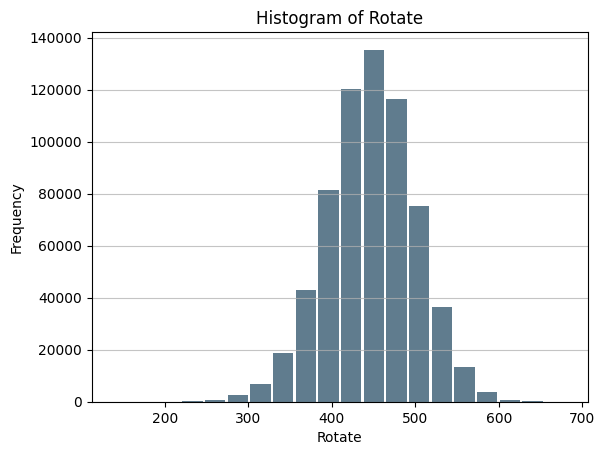

In [112]:
plot_histogram(df_PdM_telemetry, 'rotate')



In [111]:
import matplotlib.pyplot as plt

def plot_horizontal_boxplot(data, title='Box plot of data', xlabel='Box plot', ylabel='Values', vert=True, widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2), whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2)):
    plt.boxplot(data, vert=vert, widths=widths, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
873880,2015-09-30 19:00:00,100,177.465422,546.356723,104.136653,43.033768
873881,2015-09-30 20:00:00,100,184.768905,436.609450,100.804513,41.929488
873882,2015-09-30 21:00:00,100,165.606961,398.096738,91.812868,37.269570
873883,2015-09-30 22:00:00,100,180.035583,511.542831,115.793564,39.715842


In [113]:
import matplotlib.pyplot as plt

def plot_horizontal_boxplot(df, column, title='Box plot of data', xlabel='Box plot', ylabel='Values', vert=True, widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2), whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2)):
    data = df[column].tolist()
    plt.boxplot(data, vert=vert, widths=widths, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


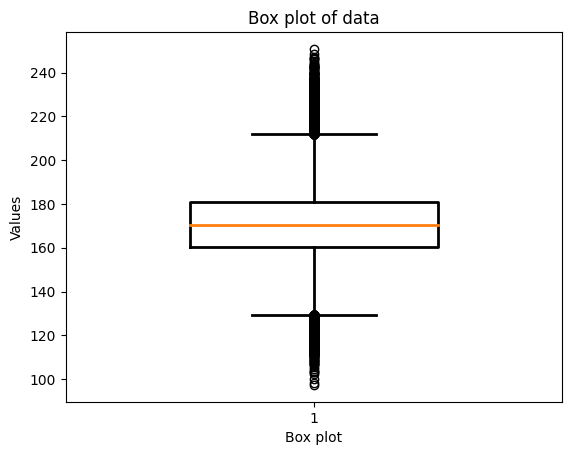

In [115]:
plot_horizontal_boxplot(df_PdM_telemetry, 'volt')


In [117]:
import matplotlib.pyplot as plt

def plot_histogram_boxplot(df, column):
    # Crear subplot con 1 fila y 2 columnas
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    # Crear histograma a la izquierda
    axs[0].hist(df[column], bins=20, rwidth=0.9, color='#607c8e')
    axs[0].set_title(f'Histograma de {column.capitalize()}')
    axs[0].set_xlabel(column.capitalize())
    axs[0].set_ylabel('Frecuencia')
    axs[0].grid(axis='y', alpha=0.75)

    # Crear diagrama de caja a la derecha
    axs[1].boxplot(df[column], vert=True, widths=0.5, boxprops=dict(linewidth=2), medianprops=dict(linewidth=2), whiskerprops=dict(linewidth=2), capprops=dict(linewidth=2))
    axs[1].set_title(f'Diagrama de caja de {column.capitalize()}')
    axs[1].set_xlabel(column.capitalize())
    axs[1].set_ylabel('Valores')

    # Ajustar el espaciado entre subplots
    plt.tight_layout()

    # Mostrar subplot
    plt.show()


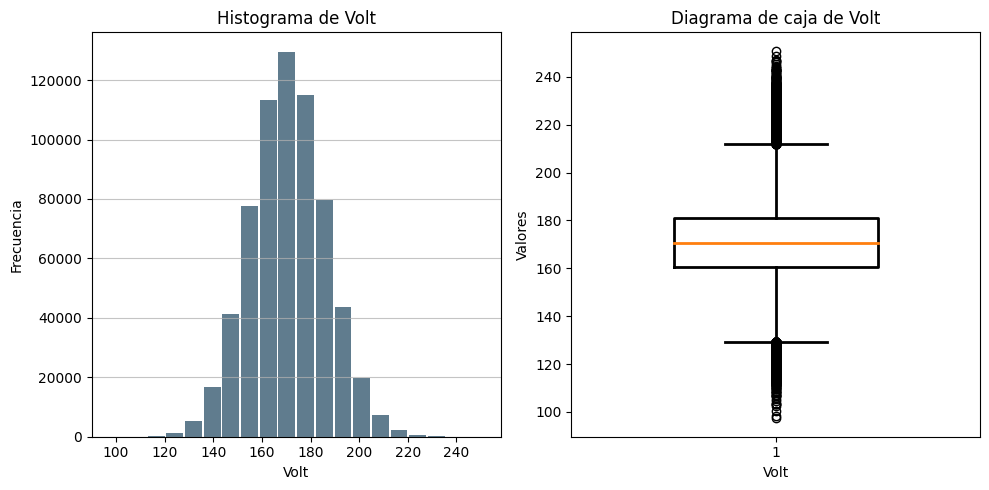

In [118]:

plot_histogram_boxplot(df_PdM_telemetry, 'volt')
